### Orderbooks and Asset Pricing

## Question 1 : Building Order Book class

In [ ]:
# Convert Mac pickles to Windows pickle
original = "./THO"
destination = "./data/THO"

content = ''
outsize = 0
with open(original, 'rb') as infile:
    content = infile.read()
with open(destination, 'wb') as output:
    for line in content.splitlines():
        outsize += len(line) + 1
        output.write(line + str.encode('\n'))

print("Done. Saved %s bytes." % (len(content)-outsize))

In [ ]:
import pandas as pd
import pickle

AAPL = pd.read_pickle('./data/AAPL')
C = pd.read_pickle('./data/C')
GBX = pd.read_pickle('./data/GBX')
SPY = pd.read_pickle('./data/SPY')
THO = pd.read_pickle('./data/THO')

In [375]:
import pandas as pd
from matplotlib import pyplot as plt
import statsmodels.api as sm
import seaborn as sns

class Orderbook:
    """An orderbook class.
    Attributes:
    data (DataFrame): Price, quantity and type of order.
    timestamp (int): date
    """
    def __init__(self, data): # This function is the constructor.
        """Set the name and initialize an empty list of contents.
        Parameters:
        data (dict): dictionary including price, quantity and direction
        """
        self.timestamp = data[0]
        frame = pd.DataFrame.from_dict(data[1], orient="index")
        frame = frame.drop(columns=[2, 3])
        frame['Price'] = frame.index
        frame.index = range(len(frame))
        frame.rename(columns={0:"Quantity", 1:"Order"}, inplace=True)
        
        maxv = frame[frame['Order'] == "B"]['Price'].max()
        minv = frame[frame['Order'] == "S"]['Price'].min()
        self.midpoint = (minv + maxv)/2
        
        frame = frame[np.abs(frame.Price-self.midpoint) < (2*frame.Price.std())]
        frame = frame[frame["Quantity"] < frame["Quantity"].quantile(0.80)]
        frame['Selling'] = (frame['Order'] == "S")*1 - (frame['Order'] == "B")*1
        frame['Lbook'] = frame[frame['Order'] == "B"].sort_values(by='Price', ascending=False)["Quantity"].cumsum()
        frame['Lbook'] = frame['Lbook'].fillna(0)
        frame['Rbook'] = frame[frame['Order'] == "S"].sort_values(by='Price', ascending=True)["Quantity"].cumsum()
        frame['Rbook'] = frame['Rbook'].fillna(0)
        frame['book'] = frame['Rbook'] - frame['Lbook']
        frame['Orders'] = frame['Selling'] * frame['Quantity']

        
        self.data = frame



    def get_params(self, σ):
        """Estimate Kyle Model on order book"""
        X = self.data[np.abs(self.data.Price-self.midpoint) < (σ*self.data.Price.std())]['Price']
        X = sm.add_constant(X.values)
        model = sm.OLS(self.data[np.abs(self.data.Price-self.midpoint) < (σ*self.data.Price.std())]['book'],X)
        results = model.fit()
        return results.params
        
    
    def plot(self, σ):
        """Plot the order book and the estimated equation"""
        X = self.data.sort_values(by='Price', ascending=True)[np.abs(self.data.Price-self.midpoint) < (σ*self.data.Price.std())]
        X.plot(x='Price', y='book')
        sns.regplot(x="Price", y="book", data= X)
        


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


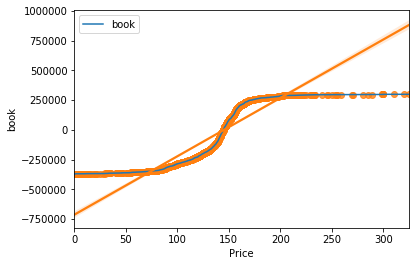

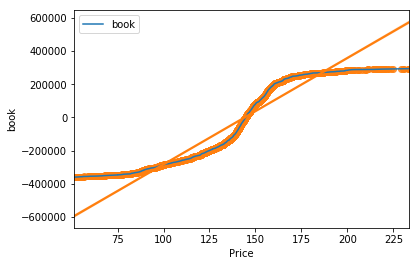

In [367]:

#get date
#print(AAPL[5][0])

#get all data
#print(AAPL[5][1])

# get price
#print(AAPL[5][1].keys())

# get the order
#print(AAPL[5][1][0])

#get the number of share
#print(AAPL[5][1][0][0])

#get the number of share
#print(AAPL[5][1][0][0])


data = AAPL[1]
# print(AAPL[5][1])
# test1 = pd.DataFrame.from_dict(data[1], orient="index")
# print(test1[0])


test = Orderbook(data)
test.get_params(1)
test.midpoint
test.plot(1)
test.plot(0.5)


## Question 2: Plot estimated market liquidity

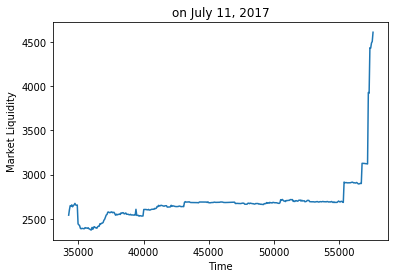

In [385]:

def liquidity(stock, σ):
    liquidity = []
    time = []
    for i, item in enumerate(stock):
        book = Orderbook(item)
        liquidity.append(book.get_params(1)[1])
        time.append(book.timestamp)

    plt.plot(time, liquidity)
    plt.title('on July 11, 2017')
    plt.ylabel('Market Liquidity')
    plt.xlabel('Time')
    plt.show()

liquidity(AAPL,0.1)


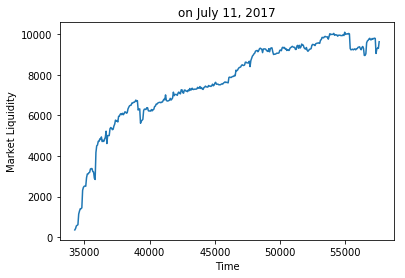

In [371]:
liquidity(GBX,1)

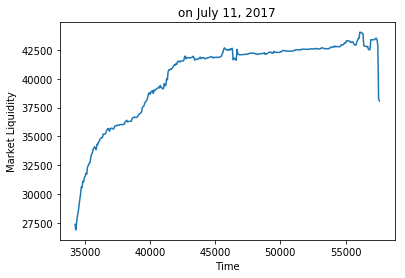

In [372]:
liquidity(C,1)

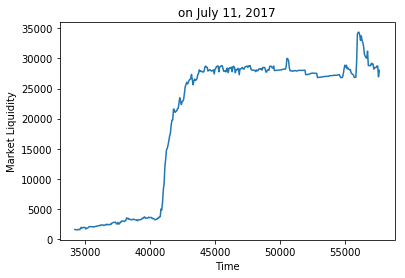

In [373]:
liquidity(SPY,1)

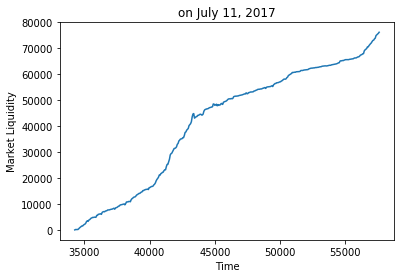

In [374]:
liquidity(THO,1)

### Question 3: Estimated midpoint

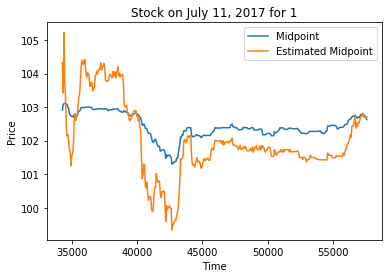

In [378]:

def findp0(stock,σ):
    p0 = []
    midpoint = []
    time = []
    for i, item in enumerate(stock):
        book = Orderbook(item)
        p0.append(-book.get_params(σ)[0]/book.get_params(σ)[1])
        midpoint.append(book.midpoint)
        time.append(book.timestamp)

    # Timeperiod = pd.date_range("08:00", "17:30", freq="1min")
    plt.plot(time, midpoint)
    plt.plot(time, p0)
    plt.title('Stock on July 11, 2017 for %i' % σ)
    plt.ylabel('Price')
    plt.legend(['Midpoint', 'Estimated Midpoint'])
    plt.xlabel('Time')
    plt.show()
    
findp0(THO,1)

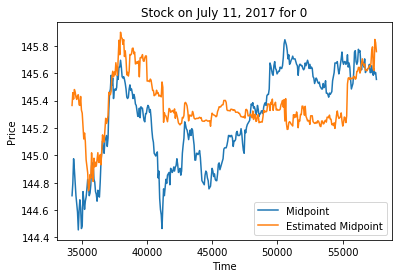

In [379]:
findp0(AAPL,0.1)

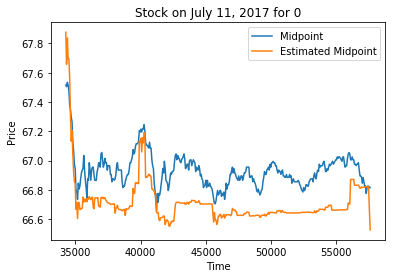

In [380]:
findp0(C,0.1)

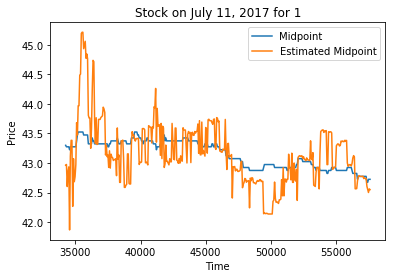

In [381]:
findp0(GBX,1)

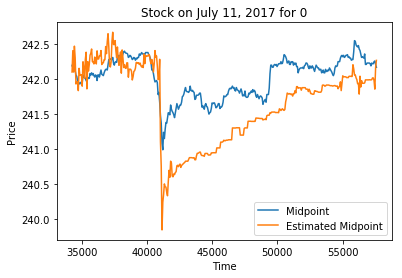

In [384]:
findp0(SPY,0.1)